# A Manual Regristation Pipeline for Processing

In [22]:
import numpy as np
import copy
import open3d as o3d
import os
import sys

from numpy.linalg import inv

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

## Utility Functions

In [23]:
def demo_crop_geometry():
    print("Demo for manual geometry cropping")
    print(
        "1) Press 'Y' twice to align geometry with negative direction of y-axis"
    )
    print("2) Press 'K' to lock screen and to switch to selection mode")
    print("3) Drag for rectangle selection,")
    print("   or use ctrl + left click for polygon selection")
    print("4) Press 'C' to get a selected geometry and to save it")
    print("5) Press 'F' to switch to freeview mode")
    pcd = o3d.io.read_point_cloud("../../test_data/ICP/cloud_bin_0.pcd")
    o3d.visualization.draw_geometries_with_editing([pcd])

def draw_registration_color(source,target,transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])    

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])
    
def pick_points(pcd, filename, fileid):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press 'Q' to close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.capture_screen_image("results/%s_%d.png" % (filename, fileid))    
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

## Pair-Wise Registration
### left view
|Source|Target|
|---|---|
|1|2|
|1|3|
|3|4|

### right view
|Source|Target|
|---|---|
|5|6|
|5|7|
|7|8|

### top view
|Source|Target|
|---|---|
|9|1|
|9|5|

### Suggested order:

left12, left13, left34, right56, right57, right78, top91, top95

# Load 2 PointClouds (PLY Files) and visualize them

Visualization of two point clouds before manual alignment


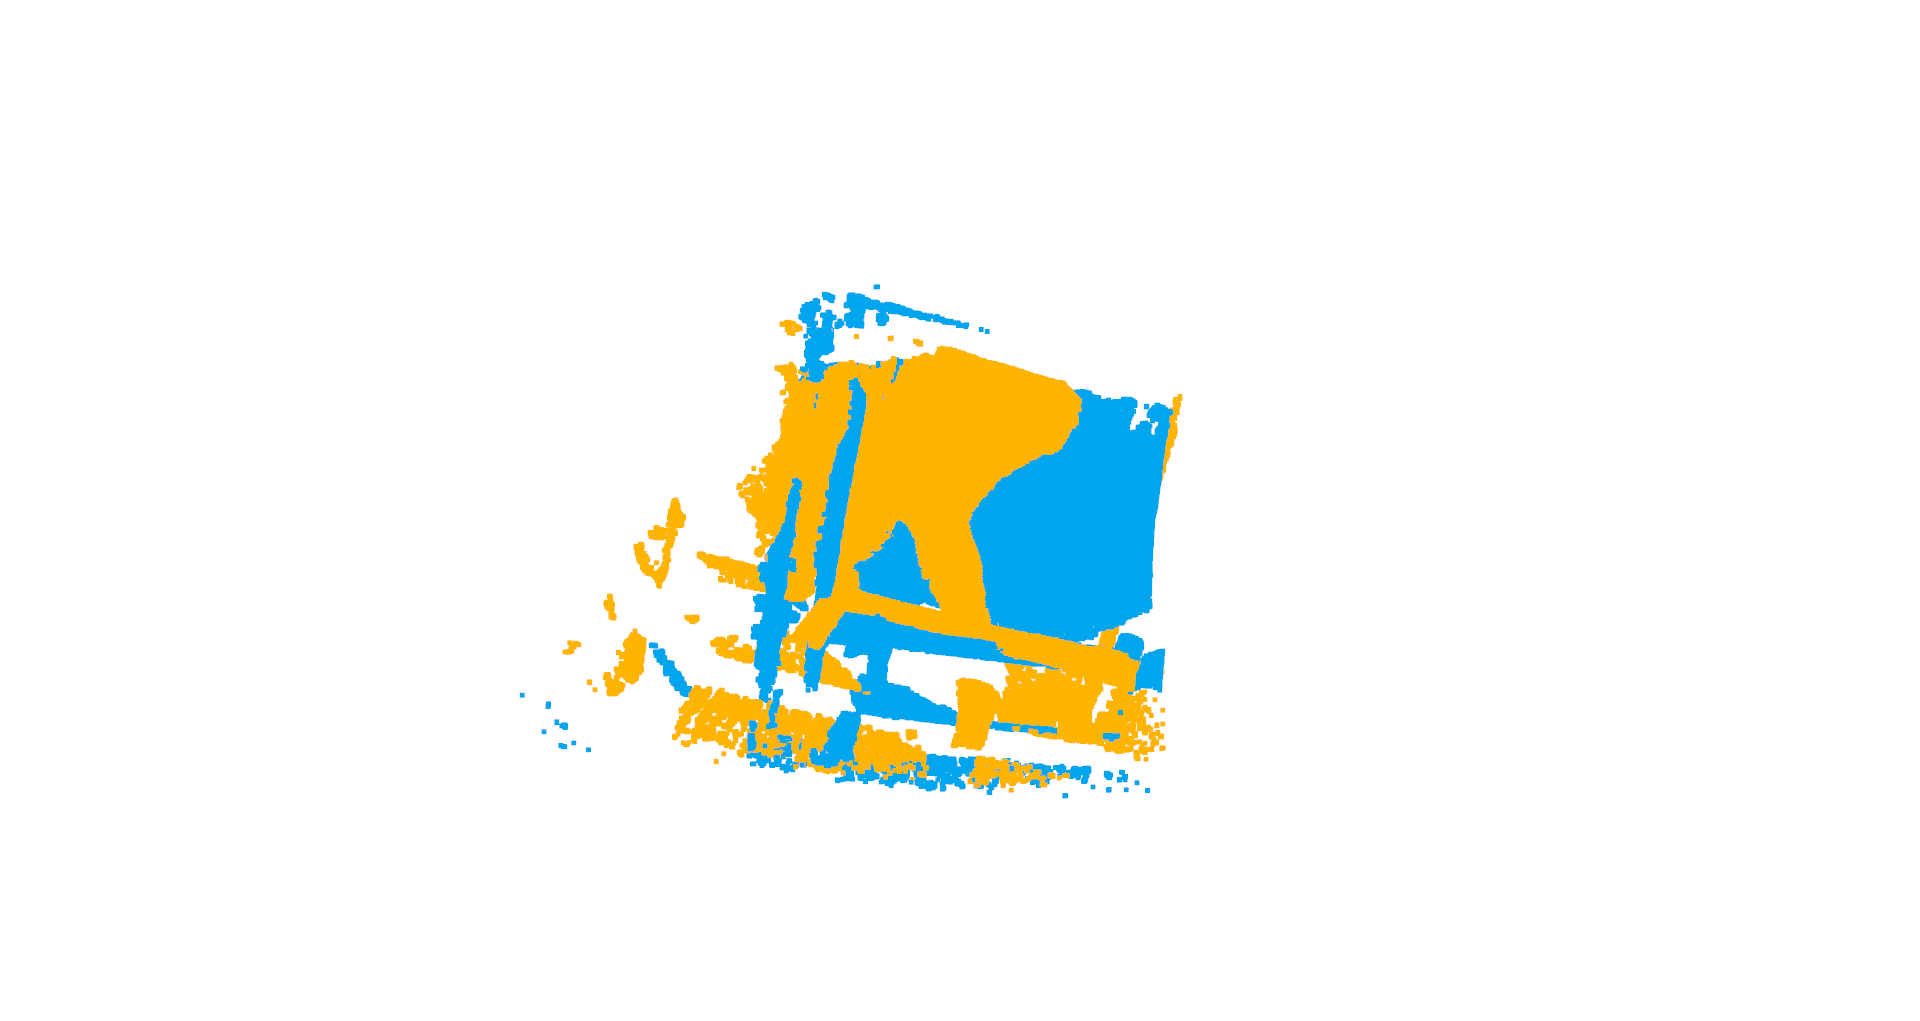

In [24]:
filepath = '/home/pupil/elitton/Cow_project/new_images/all_unregistered/186_full_plys/model_001/'

exp_name = 'left13'
source_id = 1
target_id = 3

source = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, source_id))
target = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, target_id))
print("Visualization of two point clouds before manual alignment")
draw_registration_result(source, target, np.identity(4))

# Pick corresponding points to determine ICP (Iterative closest point algorithm) Initialization

In [39]:
# pick points from two point clouds and builds correspondences
picked_id_source = pick_points(source, exp_name, source_id)
picked_id_target = pick_points(target, exp_name, target_id)

assert (len(picked_id_source) >= 3 and len(picked_id_target) >= 3)
assert (len(picked_id_source) == len(picked_id_target))

# corr contains the correspondence points
# TO-DO: Save the correspondence points for future conveniences
corr = np.zeros((len(picked_id_source), 2))
corr[:, 0] = picked_id_source
corr[:, 1] = picked_id_target


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Picked point #9068 (-0.5, -0.25, 0.92) to add in queue.
[Open3D INFO] Remove picked point #9068 from pick queue.
[Open3D INFO] Picked point #7702 (-0.5, -0.25, 0.88) to add in queue.
[Open3D INFO] Remove picked point #7702 from pick queue.
[Open3D INFO] Picked point #7168 (-0.51, -0.24, 0.89) to add in queue.
[Open3D INFO] Picked point #4819 (-0.55, -0.043, 0.92) to add in queue.
[Open3D INFO] Picked point #19962 (-0.49, 0.19, 1.1) to add in queue.
[Open3D INFO] Picked point #14282 (-0.92, 0.67, 1.8) to add in queue.
[Open3D WARNING] Write PNG failed: unable to write file: results/left13_1.png


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Picked

# Use Picked Points to transform the source to the target coordinate frame

In [40]:
# estimate rough transformation using correspondences
print("Compute a rough transform using the correspondences given by user")
p2p = o3d.pipelines.registration.TransformationEstimationPointToPoint()
trans_init = p2p.compute_transformation(source, target,
                                        o3d.utility.Vector2iVector(corr))
print(trans_init)

Compute a rough transform using the correspondences given by user
[[ 0.97176189  0.06889273 -0.22568258  1.11921014]
 [-0.05854442  0.99691714  0.05223755 -0.02582337]
 [ 0.22858562 -0.03755     0.97279937 -0.01514027]
 [ 0.          0.          0.          1.        ]]


# Plot the Initial Alignment

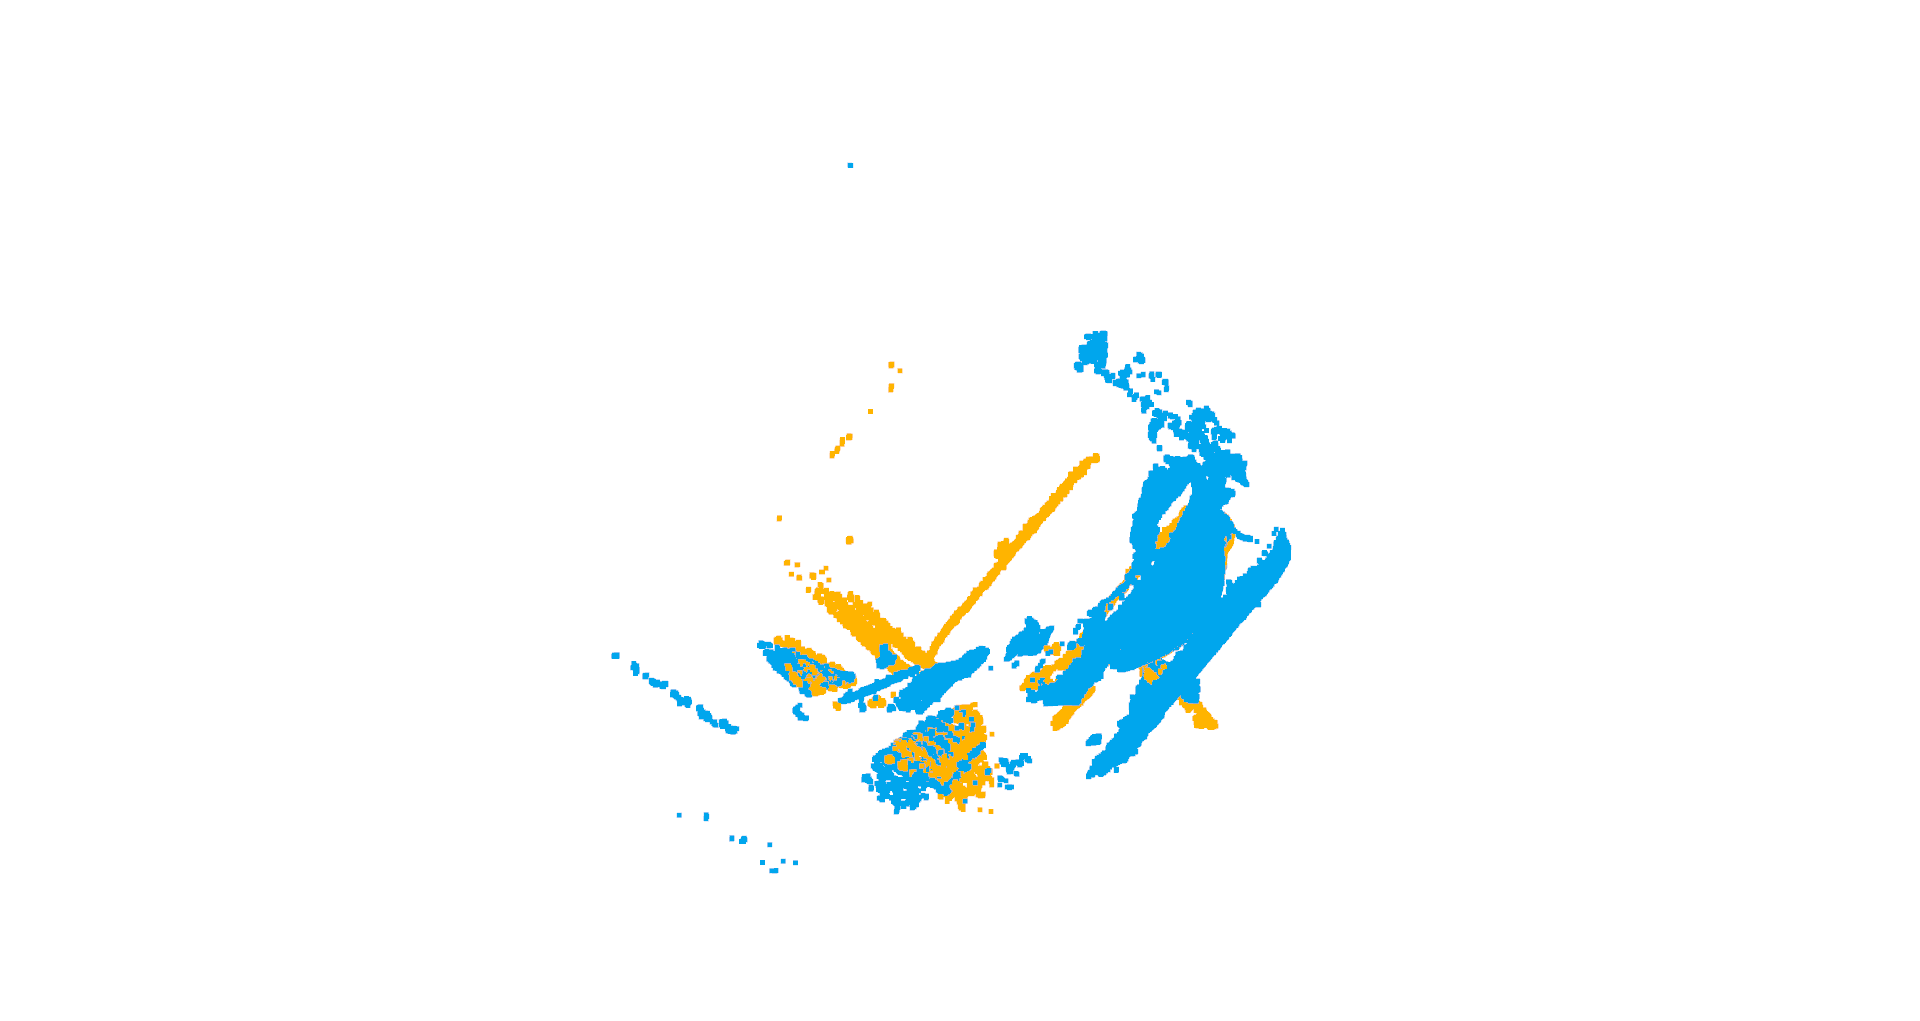

In [41]:
draw_registration_result(source,target,trans_init)

# Iterative closest point algorithm

In [42]:
# point-to-point ICP for refinement
print("Perform point-to-point ICP refinement")
threshold = 0.03 # 3cm distance threshold
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p.transformation)

Perform point-to-point ICP refinement
[[ 0.97280594  0.09389905 -0.21173468  1.08148208]
 [-0.08690654  0.99532592  0.04211381 -0.01735286]
 [ 0.21469946 -0.02256743  0.9764194  -0.02753862]
 [ 0.          0.          0.          1.        ]]


# Plot the result of the Iterative closest point algorithm

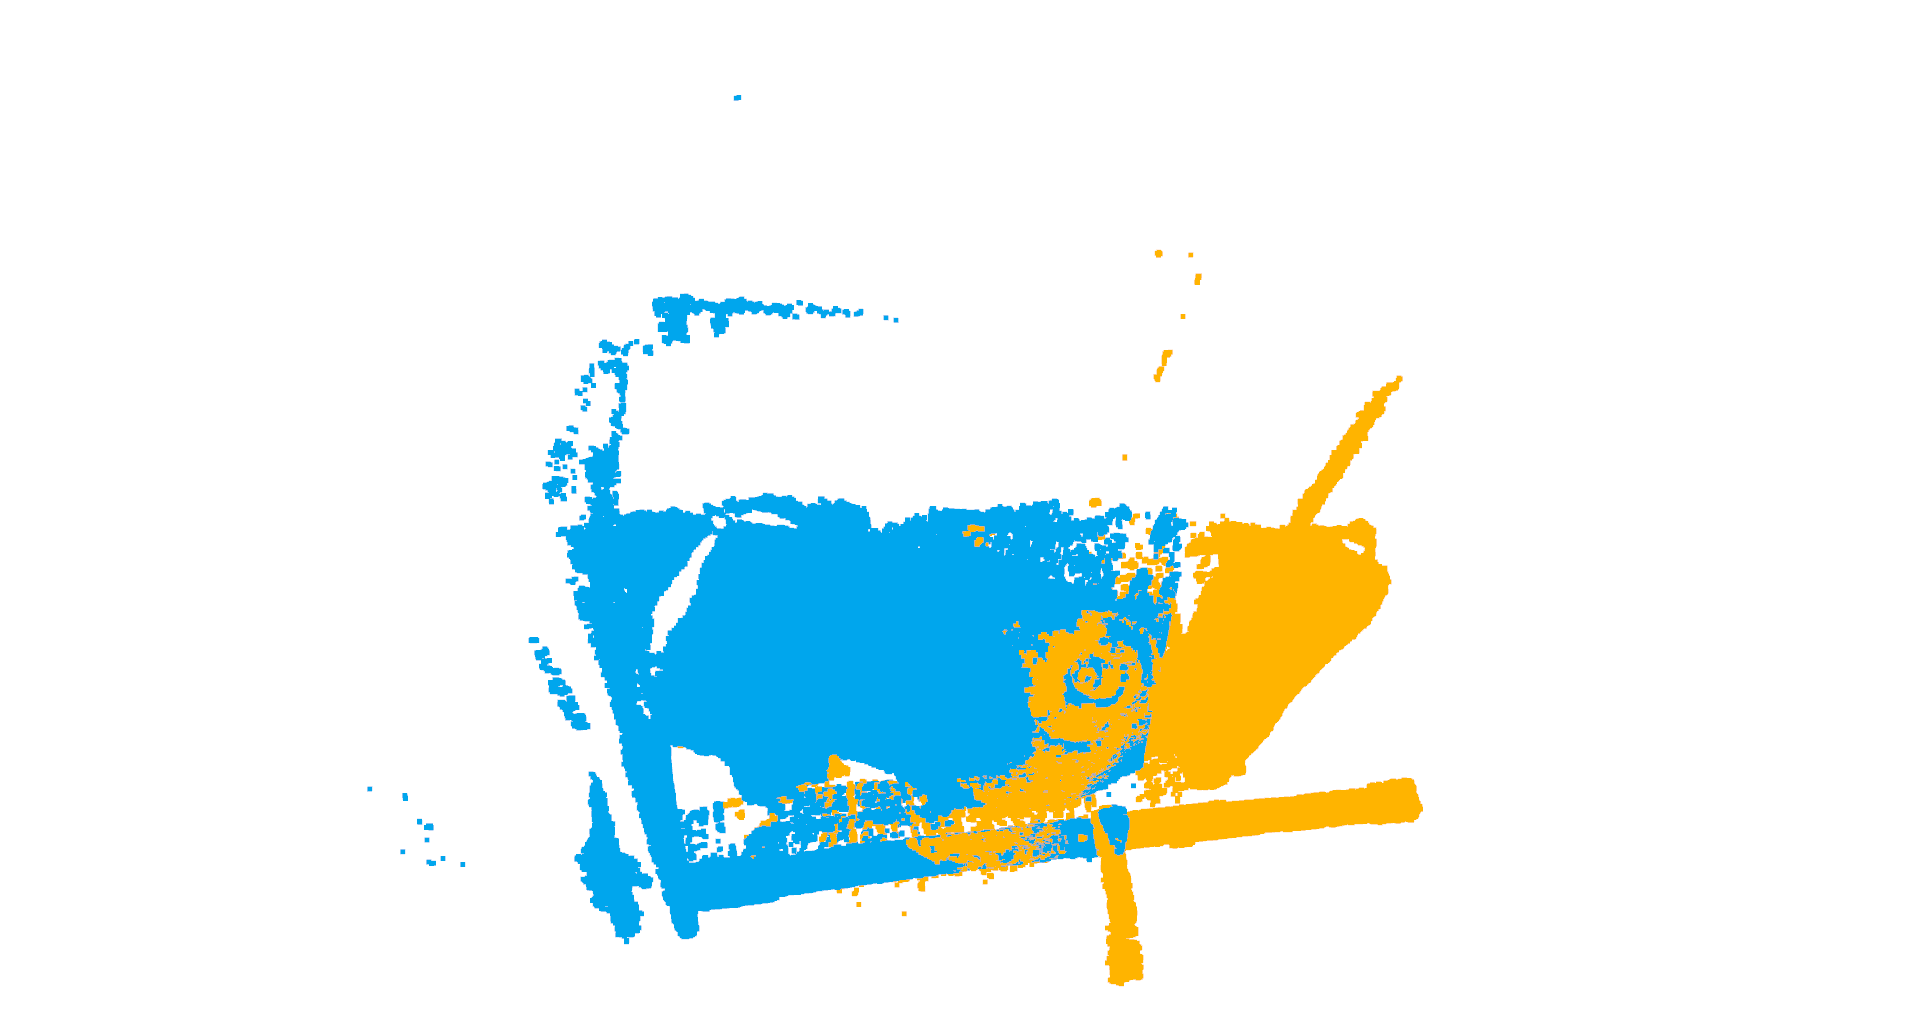

In [43]:
draw_registration_result(source,target,reg_p2p.transformation)

In [27]:
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh_176.vertices
density_mesh.triangles = mesh_176.triangles
density_mesh.triangle_normals = mesh_176.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)

NameError: name 'densities' is not defined

In [28]:
o3d.visualization.draw_geometries([density_mesh])

NameError: name 'density_mesh' is not defined

In [ ]:
)

In [29]:
# pick points from two point clouds and builds correspondences
picked_id_source = pick_points(source, exp_name, source_id)
picked_id_target = pick_points(target, exp_name, target_id)

assert (len(picked_id_source) >= 3 and len(picked_id_target) >= 3)
assert (len(picked_id_source) == len(picked_id_target))

# corr contains the correspondence points
# TO-DO: Save the correspondence points for future conveniences
corr = np.zeros((len(picked_id_source), 2))
corr[:, 0] = picked_id_source
corr[:, 1] = picked_id_target


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D WARNING] Write PNG failed: unable to write file: results/left13_1.png


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D WARNING] Write PNG failed: unable to write file: results/left13_3.png



AssertionError: 

In [ ]:
# estimate rough transformation using correspondences
print("Compute a rough transform using the correspondences given by user")
p2p = o3d.pipelines.registration.TransformationEstimationPointToPoint()
trans_init = p2p.compute_transformation(source, target,
                                        o3d.utility.Vector2iVector(corr))
print(trans_init)

In [ ]:
trans_init = np.eye(4,4)
H_source = np.eye(4,4)
H_source[2,3] = -0.5
H_source[1,3] = 0
H_source[0,3] = 0
print(H_source)

In [ ]:
downpcd = source_temp.voxel_down_sample(voxel_size=0.05)

In [ ]:
o3d.visualization.draw_geometries([downpcd])
source_temp.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

In [ ]:
source_temp = copy.deepcopy(source)
source_temp.transform(H_source)
o3d.visualization.draw_geometries([target,source_temp])
o3d.geometry.estimate_normals(
        source_temp,
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,
                                                          max_nn=30))

In [ ]:
# point-to-point ICP for refinement
print("Perform point-to-point ICP refinement")
threshold = 3e-1# 3cm distance threshold
reg_p2p = o3d.pipelines.registration.registration_icp(
    source_temp, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2p.transformation)

In [ ]:
#draw_registration_result(source, target, reg_p2p.transformation)
draw_registration_color(source_temp, target, reg_p2p.transformation)
print("")


In [ ]:
fpath = '/home/cornea/goowfd/Documents/cow_data_elit/old_ply_186_elit_clean_before'
source2 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (fpath, source_id))
target2 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (fpath, target_id))

In [ ]:
# pick points from two point clouds and builds correspondences
picked_id_source = pick_points(source2, exp_name, source_id)
picked_id_target = pick_points(target2, exp_name, target_id)

assert (len(picked_id_source) >= 3 and len(picked_id_target) >= 3)
assert (len(picked_id_source) == len(picked_id_target))

# corr contains the correspondence points
# TO-DO: Save the correspondence points for future conveniences
corr = np.zeros((len(picked_id_source), 2))
corr[:, 0] = picked_id_source
corr[:, 1] = picked_id_target

In [ ]:
print("Compute a rough transform using the correspondences given by user")
p2p = o3d.pipelines.registration.TransformationEstimationPointToPoint()
trans_init2 = p2p.compute_transformation(source2, target2,
                                        o3d.utility.Vector2iVector(corr))
print(trans_init2)

In [ ]:
print("Perform point-to-point ICP refinement")
threshold = 3e-10  # 3cm distance threshold
reg_p2p = o3d.pipelines.registration.registration_icp(
    source2, target2, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p.transformation)

In [ ]:
draw_registration_result(source2, target2, reg_p2p.transformation)

In [ ]:
pwd

In [ ]:
H12 = np.loadtxt('htms/left12_transform.txt', delimiter=',')
target2.transform(inv(H12))
o3d.visualization.draw_geometries([source2,target2])

In [ ]:
threshold = 3e-10  # 3cm distance threshold
reg_p2p2 = o3d.pipelines.registration.registration_icp(
    source2, target2, threshold,H12,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p2.transformation)

In [ ]:
draw_registration_result(source2, target2, reg_p2p2.transformation)

In [ ]:
# Save the parameters
np.savetxt('results/%s_corr.txt' % (exp_name), corr, delimiter=',')
np.savetxt('results/%s_transform.txt' % (exp_name), reg_p2p.transformation, delimiter=',')

## Register all Point Clouds (Left, Right, Top)

In [ ]:
# Load all point clouds
source  = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 9))

left1   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 1))
left2   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 2))
left3   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 3))
# left4   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 4))

right5 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 5))
right6 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 6))
right7 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 7))
right8 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 8))

# Load all transformations
H91 = np.loadtxt('results/top91_transform.txt', delimiter=',')
H95 = np.loadtxt('results/top95_transform.txt', delimiter=',')

H12 = np.loadtxt('results/left12_transform.txt', delimiter=',')
H13 = np.loadtxt('results/left13_transform.txt', delimiter=',')
# H34 = np.loadtxt('results/right78_transform.txt', delimiter=',')

H56 = np.loadtxt('results/right56_transform.txt', delimiter=',')
H57 = np.loadtxt('results/right57_transform.txt', delimiter=',')
H78 = np.loadtxt('results/right78_transform.txt', delimiter=',')

In [ ]:
# Register with colored point clouds
source_temp = copy.deepcopy(source)

left1_temp = copy.deepcopy(left1)
left2_temp = copy.deepcopy(left2)
left3_temp = copy.deepcopy(left3)
# left4_temp = copy.deepcopy(left4)

right5_temp = copy.deepcopy(right5)
right6_temp = copy.deepcopy(right6)
right7_temp = copy.deepcopy(right7)
right8_temp = copy.deepcopy(right8)

source_temp.paint_uniform_color([1, 0.7, 0])

left1_temp.paint_uniform_color([0, 0.6, 0.9])
left2_temp.paint_uniform_color([0, 0.6, 0.9])
left3_temp.paint_uniform_color([0, 0.6, 0.9])
# left4_temp.paint_uniform_color([0, 0.6, 0.9])

right5_temp.paint_uniform_color([0.9, 0, 0.2])
right6_temp.paint_uniform_color([0.9, 0, 0.2])
right7_temp.paint_uniform_color([0.9, 0, 0.2])
right8_temp.paint_uniform_color([0.9, 0, 0.2])

# target3_temp.paint_uniform_color([0.5, 0, 1])

left1_temp.transform(inv(H91))
left2_temp.transform(inv(H91) @ inv(H12))
left3_temp.transform(inv(H91) @ inv(H13))
# left4_temp.transform(inv(H91) @ inv(H13) @ inv(H34))

right5_temp.transform(inv(H95))
right6_temp.transform(inv(H95) @ inv(H56))
right7_temp.transform(inv(H95) @ inv(H57))
right8_temp.transform(inv(H95) @ inv(H57) @ inv(H78))

o3d.visualization.draw_geometries([source_temp, 
                                   left1_temp, left2_temp, left3_temp, 
                                   right5_temp, right6_temp, right7_temp, right8_temp])

In [ ]:
# Register with original point clouds
source_temp = copy.deepcopy(source)

left1_temp = copy.deepcopy(left1)
left2_temp = copy.deepcopy(left2)
left3_temp = copy.deepcopy(left3)
# left4_temp = copy.deepcopy(left4)

right5_temp = copy.deepcopy(right5)
right6_temp = copy.deepcopy(right6)
right7_temp = copy.deepcopy(right7)
right8_temp = copy.deepcopy(right8)

left1_temp.transform(inv(H91))
left2_temp.transform(inv(H91) @ inv(H12))
left3_temp.transform(inv(H91) @ inv(H13))
# left4_temp.transform(inv(H91) @ inv(H13) @ inv(H34))

right5_temp.transform(inv(H95))
right6_temp.transform(inv(H95) @ inv(H56))
right7_temp.transform(inv(H95) @ inv(H57))
right8_temp.transform(inv(H95) @ inv(H57) @ inv(H78))

o3d.visualization.draw_geometries([source_temp, 
                                   left1_temp, left2_temp, left3_temp, 
                                   right5_temp, right6_temp, right7_temp, right8_temp])

In [ ]:
%history -g

# Create PLYs from RGB and Depth data by invoking a MATLAB program

In [93]:
# Set the camera ID, relevant for data dir and Intrinsics
cam_ID = '12'

# Set the data directory for retrieving the RGB and Depth data
data_dir = 'home/cornea/goowfd/Documents/new_cow_data/176_full/v1/' + cam_ID

# Perint the contents of data dir so that you can determine the range for creating PLYs
# i.e. what startIndx and endIndx should be
!ls {'/' + data_dir + '/'}

# Set the Start and End IDX for PLY creation { range of frames to use}
startIdx = '2'
endIdx = '3'

# Set the path to the correct cameras intrinsic parameters
intrinsics_path = 'home/cornea/goowfd/Documents/Kinect_Params/IrCameraParams_' + cam_ID

# Invoke the function to create the PLYs from RGB and Depth Data
create_invoke_matlab_cmd(data_dir,startIdx,endIdx,intrinsics_path)


                            < M A T L A B (R) >
                  Copyright 1984-2017 The MathWorks, Inc.
                   R2017a (9.2.0.538062) 64-bit (glnxa64)
                             February 23, 2017

 
To get started, type one of these: helpwin, helpdesk, or demo.
For product information, visit www.mathworks.com.
 
WARNING!!! -- Loading the handheld kinect parameters
Here
\n\n**USING THE CORRECT PARAMETERS**\n\n
Given inputs for RemoveFlyingPixels() function:
             data: [1×1 struct]
    fixFlyPixFlag: 1
    flyDistCorrTh: 10
        flyDistTh: 0.0800
       flyWinSize: 1


Total number of pixel: 167827
Number of pixel below threshold: 97803
Number of flying pixel: 2956
Total number of corrected pixels: 2619

Here
\n\n**USING THE CORRECT PARAMETERS**\n\n
Given inputs for RemoveFlyingPixels() function:
             data: [1×1 struct]
    fixFlyPixFlag: 1
    flyDistCorrTh: 10
        flyDistTh: 0.0800
       flyWinSize: 1


Total number of pixel: 168771
Number of pix

In [83]:

matlab_invocation_str = "matlab -nodisplay -nosplash -nodesktop -r "
matlab_basepath_str = '''"cd('/home/cornea/goowfd/Documents/Kinect/');'''
fcn_call_data_dir_str = '''ConvertRawDepthRGB2ColorPly('/home/cornea/goowfd/Documents/c_exp/calib1_13/','''
start_end_idx_str = '''3,'v2',struct('startIndx',1,'endIndx',1,'samplingRate',1)'''
extra_params_str = ''','samplingRate',1),struct('flyWinSize',1,'flyDistTh',0.08),[],1,'M','/''' 
intrinsic_params_str = '''1,'M','/'''
tail_str = '''.txt');exit;"'''
r = matlab_invocation_str + matlab_basepath_str + fcn_call_data_dir_str + start_end_idx_str + extra_params_str + intrinsic_params_str
#os.system(r)
#ConvertRawDepthRGB2ColorPly('/home/cornea/goowfd/Documents/c_exp/calib1_13/',3,'v2',struct('startIndx',1,'endIndx',1,'samplingRate',1),struct('flyWinSize',1,'flyDistTh',0.08),[],1,'/home/cornea/goowfd/Documents/c_exp/IrParams_13.txt');

In [96]:
def create_invoke_matlab_cmd(data_dir,startIdx,endIdx,intrinsic_path):
    matlab_invocation_str = "matlab -nodisplay -nosplash -nodesktop -r "
    matlab_basepath_str = '''"cd('/home/cornea/goowfd/Documents/Kinect/');'''
    fcn_call_str = '''ConvertRawDepthRGB2ColorPly('/'''
    sIdx_str = '''/',3,'v2',struct('startIndx','''
    eIdx_str = ''','endIndx', '''
    extra_params_str = ''','samplingRate',1),struct('flyWinSize',1,'flyDistTh',0.08),[],1,'M','/''' 
    tail_str = '''.txt');exit;"'''
    cmd = matlab_invocation_str + matlab_basepath_str + fcn_call_str + data_dir + sIdx_str + startIdx + eIdx_str + endIdx + extra_params_str + intrinsics_path+tail_str
    os.system(cmd)

In [94]:
extra_params_str

",'samplingRate',1),struct('flyWinSize',1,'flyDistTh',0.08),[],1,'M','/"

In [ ]:

str1 = "matlab -nodisplay -nosplash -nodesktop -r "
str2 = '''"cd('/home/cornea/goowfd/Documents/Kinect/');'''
str3 = '''ConvertRawDepthRGB2ColorPly('/home/cornea/goowfd/Documents/c_exp/calib1_13/','''
str4 = '''3,'v2',struct('startIndx',1,'endIndx',1,'samplingRate',1)'''
str5 = ''',struct('flyWinSize',1,'flyDistTh',0.08),[],'''
str6 = '''1,'M','/home/cornea/goowfd/Documents/c_exp/IrParams_13.txt');exit;"'''
r = str1+str2 + str3 + str4 + str5 + str6
#os.system(r)
#ConvertRawDepthRGB2ColorPly('/home/cornea/goowfd/Documents/c_exp/calib1_13/',3,'v2',struct('startIndx',1,'endIndx',1,'samplingRate',1),struct('flyWinSize',1,'flyDistTh',0.08),[],1,'/home/cornea/goowfd/Documents/c_exp/IrParams_13.txt');

In [56]:
r

'matlab -nodisplay -nosplash -nodesktop -r "cd(\'/home/cornea/goowfd/Documents/Kinect/\');ConvertRawDepthRGB2ColorPly(\'/home/cornea/goowfd/Documents/c_exp/calib1_13/\',3,\'v2\',struct(\'startIndx\',1,\'endIndx\',1,\'samplingRate\',1),struct(\'flyWinSize\',1,\'flyDistTh\',0.08),[],1,\'M\',\'/home/cornea/goowfd/Documents/c_exp/IrParams_13.txt\');exit;"'

In [70]:
data_dir = '''('/'''
D = 'home/cornea/goowfd/Documents/new_cow_data/176_full/v1/11/'


depthImg_0001.png  irImg_0018.pgm	     rawDepth_0009.depth
depthImg_0002.png  irImg_0019.pgm	     rawDepth_0010.depth
depthImg_0003.png  irImg_0020.pgm	     rawDepth_0011.depth
depthImg_0004.png  irImg_0021.pgm	     rawDepth_0012.depth
depthImg_0005.png  irImg_0022.pgm	     rawDepth_0013.depth
depthImg_0006.png  irImg_0023.pgm	     rawDepth_0014.depth
depthImg_0007.png  irImg_0024.pgm	     rawDepth_0015.depth
depthImg_0008.png  mergedImg_0001.jpg	     rawDepth_0016.depth
depthImg_0009.png  mergedImg_0002.jpg	     rawDepth_0017.depth
depthImg_0010.png  mergedImg_0003.jpg	     rawDepth_0018.depth
depthImg_0011.png  mergedImg_0004.jpg	     rawDepth_0019.depth
depthImg_0012.png  mergedImg_0005.jpg	     rawDepth_0020.depth
depthImg_0013.png  mergedImg_0006.jpg	     rawDepth_0021.depth
depthImg_0014.png  mergedImg_0007.jpg	     rawDepth_0022.depth
depthImg_0015.png  mergedImg_0008.jpg	     rawDepth_0023.depth
depthImg_0016.png  mergedImg_0009.jpg	     rawDepth_0024.depth
depthImg_0017.png  m

In [47]:
print(data_dir)

/home/cornea/goowfd/Documents/new_cow_data/176_full/v1/11/


In [50]:
!ls data_dir




ls: cannot access 'data_dir': No such file or directory
